In [26]:
!pip install kerassurgeon
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import load_model
from kerassurgeon import identify 
from kerassurgeon.operations import delete_channels,delete_layer
from kerassurgeon import Surgeon

In [0]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

def normalize(x_train,x_test):
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)
    return x_train, x_test


x_train , x_test = normalize(x_train,x_test)

y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



model_1 = Sequential()

model_1.add(Conv2D(32,(3,3),activation='relu',input_shape=x_train.shape[1:]))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(32,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(64,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(10,activation='softmax'))

model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), padding='same',activation='relu',
                 input_shape=x_train.shape[1:]))

model_2.add(Conv2D(32, (3, 3),activation='relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same',activation='relu'))

model_2.add(Conv2D(64, (3, 3),activation='relu',))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512,activation='relu',))

model_2.add(Dropout(0.5))
model_2.add(Dense(10,activation='softmax',))


In [29]:
my_model = model_2
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)         

In [30]:
my_model = load_model('drive/My Drive/Colab Notebooks/model2_before_pruning.h5')
score_train = my_model.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = my_model.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])

50000/50000 [==============================] - 60s 1ms/step
Accuracy on the Train Images:  0.85504
10000/10000 [==============================] - 12s 1ms/step
Accuracy on the Test Images:  0.7661


In [31]:
def my_get_all_conv_layers(model,first_time):
    all_conv_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:6] == 'conv2d'):
            all_conv_layers.append(i)

    return all_conv_layers if (first_time==True) else all_conv_layers[1:]

def my_get_all_dense_layers(model):
    all_dense_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:5] == 'dense'):
            all_dense_layers.append(i)
    return all_dense_layers


all_dense_layers = my_get_all_dense_layers(my_model)

all_conv_layers = my_get_all_conv_layers(my_model,True)

print('All convolution layers = ',all_conv_layers,'\nAll dense layers = ',all_dense_layers)


All convolution layers =  [0, 1, 4, 5] 
All dense layers =  [9, 11]


In [0]:
def my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,graph,first_time):
    weights = list()
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    for i in all_conv_layers:
        print('{}th layer'.format(i),all_conv_layers)
        weights.append(model.layers[i].get_weights()[0])
    layer_wise_filter_sorted_indices = list()
    layer_wise_filter_sorted_values = list()
    for i in range(len(weights)):
        weight = weights[i]
        num_filters = len(weight[0,0,0,:])
        # print(num_filters)
        weights_dict = dict() 
        for j in range(num_filters):
            weights_sum = np.sum(abs(weight[:,:,:,j]))
            filtr = 'filter {}'.format(j)
            weights_dict[filtr] = weights_sum
        
        weights_dict_sorted = sorted(weights_dict.items(),key = lambda kv:kv[1]) 
        # print('L1 norm of conv2D_{} layer'.format(i+1),weights_dict_sorted)

        weight_values = list()
        filter_indices = list()

        for element in weights_dict_sorted:
            filter_indices.append(int(element[0][6:]))  # extracting the index of filter from string (tentative try to come up with better code)
            weight_values.append(element[1]) 
    
        layer_wise_filter_sorted_indices.append(filter_indices)
        layer_wise_filter_sorted_values.append(weight_values)

        if graph == True:
                x = np.arange(num_filters)
                plt.figure(i+1,figsize=(7,5))
                plt.plot(x,np.array(weight_values))
                plt.axhline(y=np.mean(np.array(weight_values)),c='r')
                for j in range(len(layer_wise_filter_sorted_values[i])):
                    if(np.mean(np.array(weight_values)) < weight_values[j]):
                        plt.axvline(x=j,c='r')
                        break

                plt.xlabel('filter number')
                plt.ylabel('L1 norm')
                plt.title('Conv2d_{}'.format(i+1))
                plt.grid(True)
                plt.style.use(['classic'])
    return layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values

In [33]:
def my_get_prune_filter_indices(model,first_time ):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model, False,first_time)
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    thresh_hold_means = list()
    for i in range(len(all_conv_layers)):
        # print(i,'/',len(all_conv_layers))
        thresh_hold_means.append(np.mean(np.array(layer_wise_filter_sorted_values[i])))
    prune_filter_indices = list()
    for i in range(len(all_conv_layers)):
        for j in range(len(layer_wise_filter_sorted_values[i])):
            if(thresh_hold_means[i] < layer_wise_filter_sorted_values[i][j]):
                prune_filter_indices.append(j)
                break
    return prune_filter_indices
prune_filter_indices = my_get_prune_filter_indices(my_model,True)
prune_filter_indices

0th layer [0, 1, 4, 5]
1th layer [0, 1, 4, 5]
4th layer [0, 1, 4, 5]
5th layer [0, 1, 4, 5]


[15, 12, 27, 20]

In [0]:
def my_delete_filters(model,first_time):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,False,first_time)
    prune_filter_indices = my_get_prune_filter_indices(model,first_time)
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    print(all_conv_layers)
    surgeon = Surgeon(my_model)
    for index,value in enumerate(all_conv_layers):
        print(value,index,prune_filter_indices[index])
        surgeon.add_job('delete_channels',model.layers[value],channels = layer_wise_filter_sorted_indices[index][0:prune_filter_indices[index]])
    model_new = surgeon.operate()
    return model_new


In [35]:
model_new = load_model('drive/My Drive/Colab Notebooks/model2_just_after_pruning.h5')
print(my_get_all_conv_layers(model_new,True))

[0, 1, 2, 5, 6]


In [36]:
model_new.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 17)        476       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 20)        3080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 20)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 37)        6697      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 44)        1469

In [37]:



score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])


50000/50000 [==============================] - 45s 898us/step
Accuracy on the Train Images:  0.28318
10000/10000 [==============================] - 9s 888us/step
Accuracy on the Test Images:  0.2702


In [38]:
model_new = load_model('drive/My Drive/Colab Notebooks/model2_after_training_pruned_model.h5')

score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])



50000/50000 [==============================] - 43s 864us/step
Accuracy on the Train Images:  0.88048
10000/10000 [==============================] - 9s 853us/step
Accuracy on the Test Images:  0.7636


1th layer [1, 4, 5]
4th layer [1, 4, 5]
5th layer [1, 4, 5]


([[14,
   8,
   3,
   16,
   17,
   13,
   1,
   5,
   18,
   2,
   9,
   19,
   28,
   23,
   15,
   0,
   6,
   12,
   30,
   11,
   25,
   26,
   20,
   22,
   31,
   24,
   10,
   27,
   21,
   4,
   29,
   7],
  [60,
   40,
   42,
   13,
   0,
   16,
   58,
   56,
   10,
   35,
   12,
   27,
   8,
   19,
   29,
   21,
   23,
   62,
   45,
   52,
   48,
   63,
   39,
   44,
   32,
   11,
   57,
   43,
   61,
   5,
   55,
   46,
   24,
   50,
   47,
   7,
   38,
   17,
   49,
   34,
   36,
   18,
   20,
   28,
   30,
   51,
   25,
   9,
   26,
   2,
   31,
   22,
   33,
   59,
   6,
   53,
   3,
   15,
   41,
   1,
   54,
   37,
   14,
   4],
  [49,
   12,
   11,
   23,
   20,
   34,
   19,
   22,
   52,
   14,
   56,
   50,
   1,
   17,
   40,
   59,
   47,
   7,
   16,
   42,
   58,
   53,
   41,
   30,
   37,
   18,
   62,
   55,
   4,
   9,
   61,
   25,
   28,
   35,
   44,
   43,
   54,
   33,
   29,
   36,
   0,
   8,
   38,
   26,
   24,
   51,
   31,
   60,
   6,
   45,
   

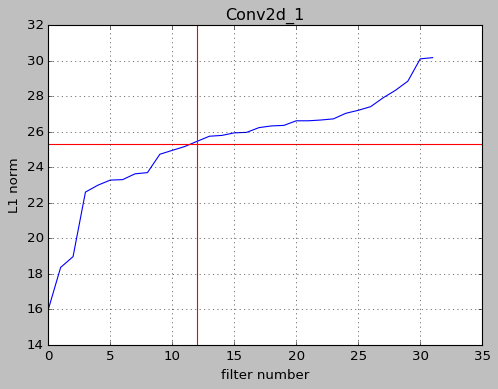

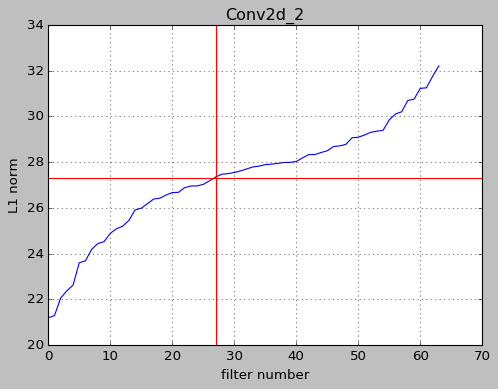

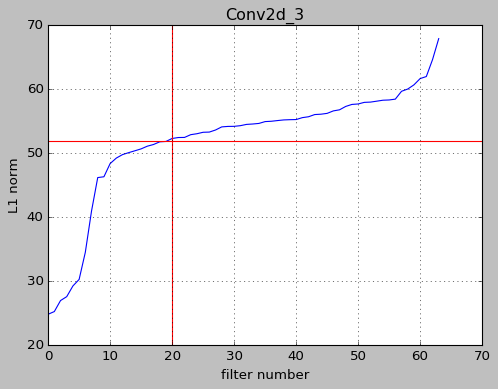

In [39]:
my_in_conv_layers_get_L1_norms_sorted_indices_and_values(my_model,graph=True,first_time = False)

In [57]:
model= load_model('drive/My Drive/Colab Notebooks/model2_before_pruning.h5')


validation_accuracy = model.evaluate(x_test,y_test)[1]
print(validation_accuracy)
max_val_acc = validation_accuracy
count = 0
while abs(max_val_acc - validation_accuracy )<=  0.05:
    print(count)
    if max_val_acc < validation_accuracy:
        max_val_acc = validation_accuracy

    if count < 1:
        model = my_delete_filters(my_model,True)
        
    else:
        conv_layers = my_get_all_conv_layers(model,False)
        a,b = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,False,False)
        thresholds = my_get_prune_filter_indices(model,False)
        
        surgeon = Surgeon(model)
        for index,value in enumerate(conv_layers):
            # print(value,index,prune_filter_indices[index])
            surgeon.add_job('delete_channels',model.layers[value],channels = a[index][0:thresholds[index]])
        model = surgeon.operate()

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2, shuffle=True)
    validation_accuracy = model.evaluate(x_test,y_test)[1]
    print("--->",validation_accuracy)
    count+=1

10000/10000 [==============================] - 13s 1ms/step
0.7661
0
0th layer [0, 1, 4, 5]
1th layer [0, 1, 4, 5]
4th layer [0, 1, 4, 5]
5th layer [0, 1, 4, 5]
0th layer [0, 1, 4, 5]
1th layer [0, 1, 4, 5]
4th layer [0, 1, 4, 5]
5th layer [0, 1, 4, 5]
[0, 1, 4, 5]
0 0 15
1 1 12
4 2 27
5 3 20
Deleting 15/32 channels from layer: conv2d_4
Deleting 12/32 channels from layer: conv2d_5
Deleting 27/64 channels from layer: conv2d_6
Deleting 20/64 channels from layer: conv2d_7
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 140s 3ms/step - loss: 0.9674 - acc: 0.6644 - val_loss: 0.8839 - val_acc: 0.6933
Epoch 2/10
40000/40000 [==============================] - 134s 3ms/step - loss: 0.7859 - acc: 0.7248 - val_loss: 0.7323 - val_acc: 0.7454
Epoch 3/10
40000/40000 [==============================] - 133s 3ms/step - loss: 0.7416 - acc: 0.7427 - val_loss: 0.7399 - val_acc: 0.7413
Epoch 4/10
40000/40000 [==============================] - 133s

In [49]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 17)        476       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 20)        3080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 37)        6697      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 44)        1469

In [54]:
my_get_all_conv_layers(my_model,True)
# a,b = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model1,False,False)
# thresholds = my_get_prune_filter_indices(model1,False)

# surgeon = Surgeon(model)
# for index,value in enumerate(conv_layers):
#     # print(value,index,prune_filter_indices[index])
#     surgeon.add_job('delete_channels',model.layers[value],channels = a[index][0:thresholds[index]])
# model = surgeon.operate()

[0, 1, 4, 5]